dataset  
- amazon review
http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Books_5.json.gz

- chABSA
https://github.com/chakki-works/chABSA-dataset


https://github.com/ShopRunner/jupyter-notify
```
pip install jupyternotify
```

install mecab and neologd if you use Japanese.

install mecab on mac
```
brew install mecab mecab-ipadic  
pip install mecab-python3
```
install neologd
```
git clone --depth 1 https://github.com/neologd/mecab-ipadic-neologd.git
cd mecab-ipadic-neologd
./bin/install-mecab-ipadic-neologd -n
```

In [ ]:
!sudo apt-get -q -y install sudo file mecab libmecab-dev mecab-ipadic-utf8 git curl python-mecab

In [ ]:
!git clone --depth 1 https://github.com/neologd/mecab-ipadic-neologd.git

In [ ]:
!echo yes | mecab-ipadic-neologd/bin/install-mecab-ipadic-neologd -n

In [ ]:
!pip install mecab-python3 tqdm

In [1]:
import tensorflow as tf
import numpy as np
import os
import time
import sys
import datetime
from tensorflow.contrib.learn import preprocessing
import pickle
import pandas as pd
from numpy.random import choice, randint
from tqdm import tqdm_notebook as tqdm
from matplotlib import pyplot as plt
from sklearn.metrics import classification_report, accuracy_score

import notebookutil as nbu
sys.meta_path.append(nbu.NotebookFinder())
from util import load_data_and_labels, get_parser


%matplotlib inline
%load_ext jupyternotify

build Tokenizer
get stopwords from the web site.
Japanese stopword:  あそこ, あたり, あちら ...
English stopword: ... you've, z, zero


<IPython.core.display.Javascript object>

In [2]:
class TextCNN:

    def __init__(
        self, sequence_length, num_classes, vocab_size, embedding_size, 
        filter_sizes, num_filters, l2_reg_lambda=0.0):
        print("# classes", num_classes)
        fc_size = 2048


        self.input_x = tf.placeholder(tf.int32, [None, sequence_length], name="input_x")
        self.input_y = tf.placeholder(tf.float32, [None, num_classes], name="input_y")
        self.dropout_keep_prob = tf.placeholder(tf.float32, name="dropout_keep_prob")
        self.loss_weight = tf.placeholder(tf.float32, name="loss_ratio")

        l2_loss = tf.constant(0.0)


        with tf.device('/cpu:0'), tf.name_scope("embedding"):
            self.W = tf.Variable(tf.random_uniform([vocab_size, embedding_size], -1.0, 1.0), name="W")
            self.embedded_chars = tf.nn.embedding_lookup(self.W, self.input_x)
            self.embedded_chars_expanded = tf.expand_dims(self.embedded_chars, -1)

 
        pooled_outputs = []
        for i, filter_size in enumerate(filter_sizes):
            with tf.name_scope("conv-maxpool-%s" % filter_size):
                filter_shape = [filter_size, embedding_size, 1, num_filters]
                W = tf.Variable(tf.truncated_normal(filter_shape, stddev=0.1), name="W")
                b = tf.Variable(tf.constant(0.1, shape=[num_filters]), name="b")
                conv = tf.nn.conv2d(self.embedded_chars_expanded,W,strides=[1, 1, 1, 1],padding="VALID", name="conv")
                bn_conv = self.batch_normalization(conv) 
                h = tf.nn.relu(tf.nn.bias_add(bn_conv, b), name="relu")
                pooled = tf.nn.max_pool(h, ksize=[1, sequence_length - filter_size + 1, 1, 1],strides=[1, 1, 1, 1],padding='VALID',name="pool")
                pooled_outputs.append(pooled)


        num_filters_total = num_filters * len(filter_sizes)
        self.h_pool = tf.concat(pooled_outputs, 3)
        self.h_pool_flat = tf.reshape(self.h_pool, [-1, num_filters_total])
        

        with tf.name_scope("fc-1"):
            W = tf.Variable(tf.truncated_normal([num_filters_total,  fc_size], stddev=0.01), name="W")
            b = tf.Variable(tf.constant(0.1, shape=[ fc_size]), name="b")
            l2_loss += tf.nn.l2_loss(W)
            l2_loss += tf.nn.l2_loss(b)
            fc_1_output = tf.nn.relu(tf.nn.xw_plus_b(self.h_pool_flat, W, b), name="fc-1-out")


        with tf.name_scope("dropout-1"):
            drop_1 = tf.nn.dropout(fc_1_output, self.dropout_keep_prob)


        with tf.name_scope("fc-2"):
            W = tf.Variable(tf.truncated_normal([ fc_size, fc_size], stddev=0.01), name="W")
            b = tf.Variable(tf.constant(0.1, shape=[fc_size]), name="b")
            l2_loss += tf.nn.l2_loss(W)
            l2_loss += tf.nn.l2_loss(b)
            fc_2_output = tf.nn.relu(tf.nn.xw_plus_b(drop_1, W, b), name="fc-2-out")
            
        with tf.name_scope("dropout-2"):
            drop_2 = tf.nn.dropout(fc_2_output, self.dropout_keep_prob)


        with tf.name_scope("fc-3"):
            W = tf.Variable(tf.truncated_normal([fc_size, num_classes], stddev=0.01), name="W")
            b = tf.Variable(tf.constant(0.1, shape=[num_classes]), name="b")
            l2_loss += tf.nn.l2_loss(W)
            l2_loss += tf.nn.l2_loss(b)
            self.scores = tf.nn.xw_plus_b(drop_2, W, b, name="output")
            self.predictions = tf.argmax(self.scores, 1, name="predictions")
            
            
        with tf.name_scope("loss"):
      
            #　targets * -log(sigmoid(logits)) * pos_weight +　(1 - targets) * -log(1 - sigmoid(logits))
            losses = tf.nn.weighted_cross_entropy_with_logits(logits=self.scores, targets=self.input_y, pos_weight=self.loss_weight)
            #losses = tf.nn.softmax_cross_entropy_with_logits(logits=self.scores, labels=self.input_y)
            self.loss = tf.reduce_mean(losses) + l2_reg_lambda * l2_loss


        with tf.name_scope("accuracy"):
            correct_predictions = tf.equal(self.predictions, tf.argmax(self.input_y, 1))
            self.accuracy = tf.reduce_mean(tf.cast(correct_predictions, "float"), name="accuracy") 
            
            
    def batch_normalization(self, x):
        """
          x -> γ(x-μ)/√（σ^2-ε）　+ β
      
          γ : scale
          μ: mean (first moment)
          σ: variance (second moment)
          β: offset
          ε: to avoid dividing by 0
        """
        epsilon = 1e-5
        dim = x.get_shape()[-1]
        scale = tf.Variable(tf.ones([dim]))
        offset = tf.Variable(tf.zeros([dim]))
        mean, variance = tf.nn.moments(x, [0,1,2])
        return tf.nn.batch_normalization(x, mean, variance, offset, scale, epsilon)

In [3]:
#positive_data_file = "data/amazon/book_pos.txt"
#negative_data_file = "data/amazon/book_neg.txt"

#positive_data_file = "data/chABSA/pos.txt"
#negative_data_file = "data/chABSA/neg.txt"

positive_data_file = "data/amazon_ja/pos.txt"
negative_data_file = "data/amazon_ja/neg.txt"

In [4]:
class Tokenizer:
    def __init__(self, parser=None):
        if parser:
            self.parser = parser
        else:
            self.parser = get_parser()
            

    def tokenize(self, text):
        text = text.lower()
        l = [line.split("\t") for line in self.parser(text).split("\n")]
        res = " ".join([i[2] for i in l if len(i) >=4]) # has POS.)
        return res

In [5]:
t = Tokenizer()
t.tokenize("認めたくないものだな。自分自身の若さ故の過ちというものを。")

'認める たい ない もの だ な 。 自分自身 の 若さ故の過ち という もの を 。'

In [6]:
%%notify
level= "sentencepiece"#"char" #"word"
x_text, y, ratio = load_data_and_labels(positive_data_file, negative_data_file, level=level, lang="Ja", tokenizer=t)

start to load data and labels.
model name: m_10000.model
True
# pos:  62402
# neg:  9060
pos/neg: 6.887637969094922


<IPython.core.display.Javascript object>

In [7]:
long_doc = True

In [8]:
len(x_text)

71462

In [9]:
x_text[0][:300]

'書き込み 、 読み 出し 、 転送速度 、 いずれ も 満足です 。 1 600 万 画 素 の コンパクト カメラ タイプの デ ジ カ メ に入れて 撮影 に 使い 、 撮影 後は カード リー ダ に 接続 して 、 撮影 した 膨 大 な 量 の 画像 データ を サ ム ネ イル 表示 に したり 、 ピック アップ した 画像 を コ ピ ペ したり していますが 、 とくに ストレス を感じる ことなく 、 快適に 使えています 。【 Amazon . co . jp 限定 】 の 個 体 は 、 SD カード 本体が シンプルな 小さい ボール 紙 に 挟 まれ ている だけ '

In [10]:
length_list = np.array([len(r)for r in x_text])

In [11]:
df = pd.DataFrame(length_list, columns=["length"])
df.head()

,length
0,401
1,44
2,122
3,150
4,221


In [12]:
df.describe(percentiles=[0.5,0.75,0.8,0.9,0.95])

,length
count,71462.000000
mean,181.499748
std,254.081839
min,3.000000
50%,121.000000
75%,207.000000
80%,236.000000
90%,345.000000
95%,492.000000
max,13372.000000


In [13]:
#df.quantile(0.95)["length"]

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1ca1d47eb8>]],
      dtype=object)

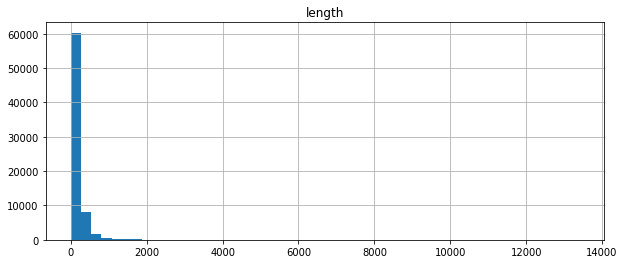

In [14]:
df.hist(bins=50,figsize=(10,4))

In [15]:
max_length = int(df.quantile(0.9)["length"]) #1000

In [16]:
#max_length = 471

In [17]:
if long_doc:
    print("cut length to ", max_length)
    x_text = [x[:max_length] if len(x) > max_length else x for x in x_text]
length_list = np.array([len(r)for r in x_text])
df = pd.DataFrame(length_list, columns=["length"])
df.describe(percentiles=[0.5,0.75,0.8,0.9,0.95])

cut length to  345


,length
count,71462.000000
mean,150.051860
std,95.909721
min,3.000000
50%,121.000000
75%,207.000000
80%,236.000000
90%,345.000000
95%,345.000000
max,345.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1ca271b128>]],
      dtype=object)

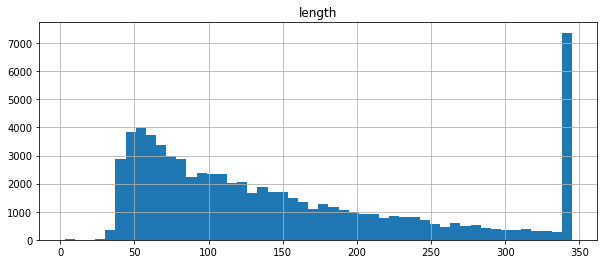

In [18]:
df.hist(bins=50,figsize=(10,4))

In [19]:
vocab_processor = preprocessing.VocabularyProcessor(max_length)

Instructions for updating:
Please use tensorflow/transform or tf.data.
Instructions for updating:
Please use tensorflow/transform or tf.data.


In [20]:
len(x_text)

71462

In [21]:
%%notify
x = np.array(list(vocab_processor.fit_transform(x_text)))

Instructions for updating:
Please use tensorflow/transform or tf.data.


<IPython.core.display.Javascript object>

In [22]:
test_percentage = 0.03 #0.0010 #0.1

In [23]:
%%notify
np.random.seed(10)
shuffle_indices = np.random.permutation(np.arange(len(y)))
x_shuffled = x[shuffle_indices]
y_shuffled = y[shuffle_indices]

test_sample_index = -1 * int(test_percentage * float(len(y)))
x_train, x_test = x_shuffled[:test_sample_index], x_shuffled[test_sample_index:]
y_train, y_test = y_shuffled[:test_sample_index], y_shuffled[test_sample_index:]

#del x, y, x_shuffled, y_shuffled

print("Vocabulary Size: {:d}".format(len(vocab_processor.vocabulary_)))
print("Train/Test split: {:d}/{:d}".format(len(y_train), len(y_test)))

Vocabulary Size: 11109
Train/Test split: 69319/2143


<IPython.core.display.Javascript object>

In [24]:
print(x_train.shape)

(69319, 345)


In [25]:
def batch_iter(data, batch_size, num_epochs, shuffle=True):
    data = np.array(data)
    data_size = len(data)
    num_batches_per_epoch = int((len(data)-1)/batch_size) + 1
    print("num of epochs: ", num_epochs)
    print("num of batches: ", num_batches_per_epoch)
    print("num of step: ", num_batches_per_epoch*num_epochs)
    for epoch in range(num_epochs):
        if shuffle:
            shuffle_indices = np.random.permutation(np.arange(data_size))
            shuffled_data = data[shuffle_indices]
        else:
            shuffled_data = data
        for batch_num in range(num_batches_per_epoch):
            start_index = batch_num * batch_size
            end_index = min((batch_num + 1) * batch_size, data_size)
            yield shuffled_data[start_index:end_index]

In [26]:
sequence_length = x_train.shape[1]
num_classes = y_train.shape[1]
vocab_size = len(vocab_processor.vocabulary_)

In [27]:
vocab_size

11109

In [28]:
embedding_size = 128    
filter_sizes = [2,3,4,5,6]    
num_filters =128               
dropout_keep_prob = 0.5 
l2_reg_lambda = 0.01       

In [29]:
TextCNN(sequence_length, num_classes, vocab_size, embedding_size, filter_sizes, num_filters, l2_reg_lambda)

# classes 2


In [30]:
batch_size = 64                  
num_epochs = 30            
evaluate_every = 20         
num_checkpoints = 5
learning_rate = 1e-3

allow_soft_placement = True    
log_device_placement = False  

save_checkpoint = True

In [31]:
time_path = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M_%S")
time_path

'2018_11_11_11_53_39'

In [32]:
prefix = ""
out_dir = os.path.join(os.path.curdir, "runs", "{}_cnn_{}".format(level, num_classes), time_path, prefix)
print("Writing to {}\n".format(out_dir))

Writing to ./runs/sentencepiece_cnn_2/2018_11_11_11_53_39/



In [33]:
with tf.Graph().as_default():
    session_conf = tf.ConfigProto(
      allow_soft_placement=allow_soft_placement,
      log_device_placement=log_device_placement)
    sess = tf.Session(config=session_conf)
    
    with sess.as_default():
        
        cnn = TextCNN(sequence_length, num_classes, vocab_size, embedding_size, filter_sizes, num_filters, l2_reg_lambda)


        global_step = tf.Variable(0, name="global_step", trainable=False)
        optimizer = tf.train.AdamOptimizer(learning_rate)
        grads_and_vars = optimizer.compute_gradients(cnn.loss)
        train_op = optimizer.apply_gradients(grads_and_vars, global_step=global_step)


        grad_summaries = []
        for g, v in grads_and_vars:
            if g is not None:
                grad_hist_summary = tf.summary.histogram("{}/grad/hist".format(v.name.replace(":", "/")), g)
                sparsity_summary = tf.summary.scalar("{}/grad/sparsity".format(v.name.replace(":", "/")), tf.nn.zero_fraction(g))
                grad_summaries.append(grad_hist_summary)
                grad_summaries.append(sparsity_summary)
        grad_summaries_merged = tf.summary.merge(grad_summaries)


        loss_summary = tf.summary.scalar("loss", cnn.loss)
        acc_summary = tf.summary.scalar("accuracy", cnn.accuracy)

        train_summary_op = tf.summary.merge([loss_summary, acc_summary, grad_summaries_merged])
        
        train_summary_dir = os.path.join(out_dir, "summaries", "train")
        train_summary_writer = tf.summary.FileWriter(train_summary_dir, sess.graph)

        test_summary_op = tf.summary.merge([loss_summary, acc_summary])
        test_summary_dir = os.path.join(out_dir, "summaries", "test")
        test_summary_writer = tf.summary.FileWriter(test_summary_dir, sess.graph)

        if save_checkpoint:
            checkpoint_dir = os.path.abspath(os.path.join(out_dir, "checkpoints"))
            checkpoint_prefix = os.path.join(checkpoint_dir, "model")
            if not os.path.exists(checkpoint_dir):
                os.makedirs(checkpoint_dir)
            saver = tf.train.Saver(tf.global_variables(), max_to_keep=num_checkpoints)

  
        vocab_processor.save(os.path.join(out_dir, "vocab"))


        sess.run(tf.global_variables_initializer())

        def train_step(x_batch, y_batch):
            feed_dict = {
              cnn.input_x: x_batch,
              cnn.input_y: y_batch,
              cnn.dropout_keep_prob: dropout_keep_prob,
              cnn.loss_weight: 1.0#ratio
            }
            _, step, summaries, loss, accuracy = sess.run([train_op, global_step, train_summary_op, cnn.loss, cnn.accuracy], feed_dict)
            
            time_str = datetime.datetime.now().isoformat()
            if step % 20 == 0:
                print("{}: step {}, loss {:g}, acc {:g}".format(time_str, step, loss, accuracy))
            train_summary_writer.add_summary(summaries, step)

        def test_step(x_batch, y_batch, writer=None):
            feed_dict = {
              cnn.input_x: x_batch,
              cnn.input_y: y_batch,
              cnn.dropout_keep_prob: 1.0,
              cnn.loss_weight: 1.0
            }
            step, summaries, loss, accuracy = sess.run([global_step, test_summary_op, cnn.loss, cnn.accuracy], feed_dict)
            time_str = datetime.datetime.now().isoformat()
            print("{}: step {}, loss {:g}, acc {:g}".format(time_str, step, loss, accuracy))
            if writer:
                writer.add_summary(summaries, step)

        batches = batch_iter(list(zip(x_train, y_train)), batch_size, num_epochs)
        for batch in batches:
            x_batch, y_batch = zip(*batch)
            train_step(x_batch, y_batch)
            current_step = tf.train.global_step(sess, global_step)
            
            if current_step % evaluate_every == 0:
                print("\nEvaluation:")
                test_step(x_test, y_test, writer=test_summary_writer)
                print("")
                
            if save_checkpoint and current_step % evaluate_every == 0:
                path = saver.save(sess, checkpoint_prefix, global_step=current_step)
                print("Saved model checkpoint to {}\n".format(path))

# classes 2
num of epochs:  30
num of batches:  1084
num of step:  32520
2018-11-11T11:54:03.809066: step 20, loss 1.17568, acc 0.90625

Evaluation:
2018-11-11T11:54:16.554528: step 20, loss 1.19908, acc 0.875875

Saved model checkpoint to /Users/tdual/Workspace/char_level_cnn/runs/sentencepiece_cnn_2/2018_11_11_11_53_39/checkpoints/model-20

2018-11-11T11:54:33.237620: step 40, loss 0.771379, acc 0.90625

Evaluation:
2018-11-11T11:54:43.377388: step 40, loss 0.804034, acc 0.875875

Saved model checkpoint to /Users/tdual/Workspace/char_level_cnn/runs/sentencepiece_cnn_2/2018_11_11_11_53_39/checkpoints/model-40

2018-11-11T11:55:00.608472: step 60, loss 0.607077, acc 0.890625

Evaluation:
2018-11-11T11:55:10.886235: step 60, loss 0.611629, acc 0.875875

Saved model checkpoint to /Users/tdual/Workspace/char_level_cnn/runs/sentencepiece_cnn_2/2018_11_11_11_53_39/checkpoints/model-60

2018-11-11T11:55:27.930342: step 80, loss 0.468162, acc 0.921875

Evaluation:
2018-11-11T11:55:40.557163: 

Saved model checkpoint to /Users/tdual/Workspace/char_level_cnn/runs/sentencepiece_cnn_2/2018_11_11_11_53_39/checkpoints/model-600

2018-11-11T12:11:40.099707: step 620, loss 0.285576, acc 0.921875

Evaluation:
2018-11-11T12:11:52.892945: step 620, loss 0.295171, acc 0.90154

Saved model checkpoint to /Users/tdual/Workspace/char_level_cnn/runs/sentencepiece_cnn_2/2018_11_11_11_53_39/checkpoints/model-620

2018-11-11T12:12:17.279926: step 640, loss 0.22808, acc 0.953125

Evaluation:
2018-11-11T12:12:28.515443: step 640, loss 0.281514, acc 0.913206

Saved model checkpoint to /Users/tdual/Workspace/char_level_cnn/runs/sentencepiece_cnn_2/2018_11_11_11_53_39/checkpoints/model-640

2018-11-11T12:13:06.776976: step 660, loss 0.111553, acc 1

Evaluation:
2018-11-11T12:13:43.073378: step 660, loss 0.351319, acc 0.895007

Saved model checkpoint to /Users/tdual/Workspace/char_level_cnn/runs/sentencepiece_cnn_2/2018_11_11_11_53_39/checkpoints/model-660

2018-11-11T12:14:38.119757: step 680, loss 

2018-11-11T12:37:37.952611: step 1200, loss 0.224829, acc 0.938404

Saved model checkpoint to /Users/tdual/Workspace/char_level_cnn/runs/sentencepiece_cnn_2/2018_11_11_11_53_39/checkpoints/model-1200

2018-11-11T12:38:13.974806: step 1220, loss 0.207253, acc 0.890625

Evaluation:
2018-11-11T12:38:33.577653: step 1220, loss 0.242507, acc 0.913206

Saved model checkpoint to /Users/tdual/Workspace/char_level_cnn/runs/sentencepiece_cnn_2/2018_11_11_11_53_39/checkpoints/model-1220

2018-11-11T12:39:11.097556: step 1240, loss 0.22883, acc 0.9375

Evaluation:
2018-11-11T12:39:39.557604: step 1240, loss 0.23808, acc 0.935138

Saved model checkpoint to /Users/tdual/Workspace/char_level_cnn/runs/sentencepiece_cnn_2/2018_11_11_11_53_39/checkpoints/model-1240

2018-11-11T12:40:19.603241: step 1260, loss 0.17984, acc 0.96875

Evaluation:
2018-11-11T12:40:43.837803: step 1260, loss 0.222152, acc 0.939804

Saved model checkpoint to /Users/tdual/Workspace/char_level_cnn/runs/sentencepiece_cnn_2/2018_1

2018-11-11T12:59:06.656952: step 1800, loss 0.134904, acc 0.96875

Evaluation:
2018-11-11T12:59:20.530025: step 1800, loss 0.215396, acc 0.940737

Saved model checkpoint to /Users/tdual/Workspace/char_level_cnn/runs/sentencepiece_cnn_2/2018_11_11_11_53_39/checkpoints/model-1800

2018-11-11T12:59:46.169079: step 1820, loss 0.100005, acc 0.984375

Evaluation:
2018-11-11T13:00:01.110410: step 1820, loss 0.213222, acc 0.923472

Saved model checkpoint to /Users/tdual/Workspace/char_level_cnn/runs/sentencepiece_cnn_2/2018_11_11_11_53_39/checkpoints/model-1820

2018-11-11T13:00:27.464291: step 1840, loss 0.231384, acc 0.953125

Evaluation:
2018-11-11T13:00:40.665334: step 1840, loss 0.223809, acc 0.943537

Saved model checkpoint to /Users/tdual/Workspace/char_level_cnn/runs/sentencepiece_cnn_2/2018_11_11_11_53_39/checkpoints/model-1840

2018-11-11T13:01:08.477959: step 1860, loss 0.186791, acc 0.953125

Evaluation:
2018-11-11T13:01:21.928212: step 1860, loss 0.200462, acc 0.946804

Saved mode

2018-11-11T13:20:19.177313: step 2380, loss 0.224479, acc 0.944937

Saved model checkpoint to /Users/tdual/Workspace/char_level_cnn/runs/sentencepiece_cnn_2/2018_11_11_11_53_39/checkpoints/model-2380

2018-11-11T13:20:45.659656: step 2400, loss 0.0708173, acc 1

Evaluation:
2018-11-11T13:21:00.288719: step 2400, loss 0.206595, acc 0.942604

Saved model checkpoint to /Users/tdual/Workspace/char_level_cnn/runs/sentencepiece_cnn_2/2018_11_11_11_53_39/checkpoints/model-2400

2018-11-11T13:21:28.017067: step 2420, loss 0.130363, acc 0.984375

Evaluation:
2018-11-11T13:21:44.102391: step 2420, loss 0.203727, acc 0.943537

Saved model checkpoint to /Users/tdual/Workspace/char_level_cnn/runs/sentencepiece_cnn_2/2018_11_11_11_53_39/checkpoints/model-2420

2018-11-11T13:22:13.699100: step 2440, loss 0.0768504, acc 0.984375

Evaluation:
2018-11-11T13:22:29.735298: step 2440, loss 0.204397, acc 0.949603

Saved model checkpoint to /Users/tdual/Workspace/char_level_cnn/runs/sentencepiece_cnn_2/2018_

2018-11-11T13:39:53.734902: step 2980, loss 0.141084, acc 0.984375

Evaluation:
2018-11-11T13:40:06.507995: step 2980, loss 0.214424, acc 0.946337

Saved model checkpoint to /Users/tdual/Workspace/char_level_cnn/runs/sentencepiece_cnn_2/2018_11_11_11_53_39/checkpoints/model-2980

2018-11-11T13:40:33.638548: step 3000, loss 0.0675891, acc 1

Evaluation:
2018-11-11T13:40:51.220421: step 3000, loss 0.234806, acc 0.946337

Saved model checkpoint to /Users/tdual/Workspace/char_level_cnn/runs/sentencepiece_cnn_2/2018_11_11_11_53_39/checkpoints/model-3000

2018-11-11T13:41:17.669738: step 3020, loss 0.0919368, acc 0.984375

Evaluation:
2018-11-11T13:41:33.723915: step 3020, loss 0.22318, acc 0.946804

Saved model checkpoint to /Users/tdual/Workspace/char_level_cnn/runs/sentencepiece_cnn_2/2018_11_11_11_53_39/checkpoints/model-3020

2018-11-11T13:42:00.901108: step 3040, loss 0.111449, acc 0.984375

Evaluation:
2018-11-11T13:42:15.299525: step 3040, loss 0.201897, acc 0.94587

Saved model chec

Saved model checkpoint to /Users/tdual/Workspace/char_level_cnn/runs/sentencepiece_cnn_2/2018_11_11_11_53_39/checkpoints/model-3560

2018-11-11T14:00:59.809724: step 3580, loss 0.0633138, acc 1

Evaluation:
2018-11-11T14:01:11.363481: step 3580, loss 0.212019, acc 0.949603

Saved model checkpoint to /Users/tdual/Workspace/char_level_cnn/runs/sentencepiece_cnn_2/2018_11_11_11_53_39/checkpoints/model-3580

2018-11-11T14:01:37.506274: step 3600, loss 0.0440704, acc 1

Evaluation:
2018-11-11T14:01:50.261233: step 3600, loss 0.215566, acc 0.948203

Saved model checkpoint to /Users/tdual/Workspace/char_level_cnn/runs/sentencepiece_cnn_2/2018_11_11_11_53_39/checkpoints/model-3600

2018-11-11T14:02:15.157358: step 3620, loss 0.0725075, acc 0.984375

Evaluation:
2018-11-11T14:02:28.798364: step 3620, loss 0.210498, acc 0.94727

Saved model checkpoint to /Users/tdual/Workspace/char_level_cnn/runs/sentencepiece_cnn_2/2018_11_11_11_53_39/checkpoints/model-3620

2018-11-11T14:02:53.404543: step 364

2018-11-11T14:20:02.708901: step 4160, loss 0.20546, acc 0.937471

Saved model checkpoint to /Users/tdual/Workspace/char_level_cnn/runs/sentencepiece_cnn_2/2018_11_11_11_53_39/checkpoints/model-4160

2018-11-11T14:20:27.585041: step 4180, loss 0.112731, acc 0.984375

Evaluation:
2018-11-11T14:20:42.841844: step 4180, loss 0.21306, acc 0.944937

Saved model checkpoint to /Users/tdual/Workspace/char_level_cnn/runs/sentencepiece_cnn_2/2018_11_11_11_53_39/checkpoints/model-4180

2018-11-11T14:21:07.747631: step 4200, loss 0.0793243, acc 0.984375

Evaluation:
2018-11-11T14:21:23.083108: step 4200, loss 0.22864, acc 0.94587

Saved model checkpoint to /Users/tdual/Workspace/char_level_cnn/runs/sentencepiece_cnn_2/2018_11_11_11_53_39/checkpoints/model-4200

2018-11-11T14:21:47.461207: step 4220, loss 0.0474454, acc 1

Evaluation:
2018-11-11T14:22:00.921007: step 4220, loss 0.292872, acc 0.94727

Saved model checkpoint to /Users/tdual/Workspace/char_level_cnn/runs/sentencepiece_cnn_2/2018_11_11

2018-11-11T14:39:09.449622: step 4760, loss 0.0494957, acc 1

Evaluation:
2018-11-11T14:39:26.867004: step 4760, loss 0.248512, acc 0.948203

Saved model checkpoint to /Users/tdual/Workspace/char_level_cnn/runs/sentencepiece_cnn_2/2018_11_11_11_53_39/checkpoints/model-4760

2018-11-11T14:39:52.438739: step 4780, loss 0.187853, acc 0.984375

Evaluation:
2018-11-11T14:40:06.792417: step 4780, loss 0.253955, acc 0.95007

Saved model checkpoint to /Users/tdual/Workspace/char_level_cnn/runs/sentencepiece_cnn_2/2018_11_11_11_53_39/checkpoints/model-4780

2018-11-11T14:40:32.530428: step 4800, loss 0.0452917, acc 1

Evaluation:
2018-11-11T14:40:47.646704: step 4800, loss 0.261386, acc 0.948203

Saved model checkpoint to /Users/tdual/Workspace/char_level_cnn/runs/sentencepiece_cnn_2/2018_11_11_11_53_39/checkpoints/model-4800

2018-11-11T14:41:14.857182: step 4820, loss 0.0578722, acc 0.984375

Evaluation:
2018-11-11T14:41:28.840261: step 4820, loss 0.278486, acc 0.95147

Saved model checkpoint

Saved model checkpoint to /Users/tdual/Workspace/char_level_cnn/runs/sentencepiece_cnn_2/2018_11_11_11_53_39/checkpoints/model-5340

2018-11-11T14:59:18.679670: step 5360, loss 0.0591712, acc 0.984375

Evaluation:
2018-11-11T14:59:30.763194: step 5360, loss 0.230233, acc 0.949603

Saved model checkpoint to /Users/tdual/Workspace/char_level_cnn/runs/sentencepiece_cnn_2/2018_11_11_11_53_39/checkpoints/model-5360

2018-11-11T14:59:57.487401: step 5380, loss 0.0544657, acc 1

Evaluation:
2018-11-11T15:00:11.307495: step 5380, loss 0.243021, acc 0.951937

Saved model checkpoint to /Users/tdual/Workspace/char_level_cnn/runs/sentencepiece_cnn_2/2018_11_11_11_53_39/checkpoints/model-5380

2018-11-11T15:00:37.186193: step 5400, loss 0.102392, acc 0.96875

Evaluation:
2018-11-11T15:00:49.583494: step 5400, loss 0.216572, acc 0.949137

Saved model checkpoint to /Users/tdual/Workspace/char_level_cnn/runs/sentencepiece_cnn_2/2018_11_11_11_53_39/checkpoints/model-5400

2018-11-11T15:01:14.971930: st

2018-11-11T15:19:56.662733: step 5940, loss 0.234924, acc 0.941671

Saved model checkpoint to /Users/tdual/Workspace/char_level_cnn/runs/sentencepiece_cnn_2/2018_11_11_11_53_39/checkpoints/model-5940

2018-11-11T15:20:21.484498: step 5960, loss 0.0416021, acc 1

Evaluation:
2018-11-11T15:20:32.454096: step 5960, loss 0.277651, acc 0.949137

Saved model checkpoint to /Users/tdual/Workspace/char_level_cnn/runs/sentencepiece_cnn_2/2018_11_11_11_53_39/checkpoints/model-5960

2018-11-11T15:20:57.067967: step 5980, loss 0.0541399, acc 1

Evaluation:
2018-11-11T15:21:09.985097: step 5980, loss 0.237572, acc 0.950537

Saved model checkpoint to /Users/tdual/Workspace/char_level_cnn/runs/sentencepiece_cnn_2/2018_11_11_11_53_39/checkpoints/model-5980

2018-11-11T15:21:34.735460: step 6000, loss 0.0389273, acc 1

Evaluation:
2018-11-11T15:21:46.691870: step 6000, loss 0.249529, acc 0.95287

Saved model checkpoint to /Users/tdual/Workspace/char_level_cnn/runs/sentencepiece_cnn_2/2018_11_11_11_53_39

2018-11-11T15:38:37.365854: step 6540, loss 0.0489928, acc 1

Evaluation:
2018-11-11T15:38:48.839384: step 6540, loss 0.252564, acc 0.95147

Saved model checkpoint to /Users/tdual/Workspace/char_level_cnn/runs/sentencepiece_cnn_2/2018_11_11_11_53_39/checkpoints/model-6540

2018-11-11T15:39:12.042180: step 6560, loss 0.0498058, acc 1

Evaluation:
2018-11-11T15:39:26.610509: step 6560, loss 0.243726, acc 0.951003

Saved model checkpoint to /Users/tdual/Workspace/char_level_cnn/runs/sentencepiece_cnn_2/2018_11_11_11_53_39/checkpoints/model-6560

2018-11-11T15:39:49.826327: step 6580, loss 0.0433753, acc 1

Evaluation:
2018-11-11T15:40:05.313804: step 6580, loss 0.239559, acc 0.95147

Saved model checkpoint to /Users/tdual/Workspace/char_level_cnn/runs/sentencepiece_cnn_2/2018_11_11_11_53_39/checkpoints/model-6580

2018-11-11T15:40:28.472366: step 6600, loss 0.0424177, acc 1

Evaluation:
2018-11-11T15:40:43.151890: step 6600, loss 0.226793, acc 0.951003

Saved model checkpoint to /Users/td

2018-11-11T15:56:52.648570: step 7140, loss 0.0558055, acc 0.984375

Evaluation:
2018-11-11T15:57:05.947502: step 7140, loss 0.260008, acc 0.951003

Saved model checkpoint to /Users/tdual/Workspace/char_level_cnn/runs/sentencepiece_cnn_2/2018_11_11_11_53_39/checkpoints/model-7140

2018-11-11T15:57:28.541728: step 7160, loss 0.0542501, acc 0.984375

Evaluation:
2018-11-11T15:57:43.380868: step 7160, loss 0.242241, acc 0.95147

Saved model checkpoint to /Users/tdual/Workspace/char_level_cnn/runs/sentencepiece_cnn_2/2018_11_11_11_53_39/checkpoints/model-7160

2018-11-11T15:58:04.834318: step 7180, loss 0.0639776, acc 0.984375

Evaluation:
2018-11-11T15:58:14.857071: step 7180, loss 0.241345, acc 0.947737

Saved model checkpoint to /Users/tdual/Workspace/char_level_cnn/runs/sentencepiece_cnn_2/2018_11_11_11_53_39/checkpoints/model-7180

2018-11-11T15:58:37.842575: step 7200, loss 0.0550297, acc 1

Evaluation:
2018-11-11T15:58:50.176434: step 7200, loss 0.269039, acc 0.950537

Saved model c

2018-11-11T16:13:54.251620: step 7740, loss 0.0369175, acc 1

Evaluation:
2018-11-11T16:14:05.890394: step 7740, loss 0.249349, acc 0.949137

Saved model checkpoint to /Users/tdual/Workspace/char_level_cnn/runs/sentencepiece_cnn_2/2018_11_11_11_53_39/checkpoints/model-7740

2018-11-11T16:14:27.215213: step 7760, loss 0.0449883, acc 1

Evaluation:
2018-11-11T16:14:40.877961: step 7760, loss 0.241103, acc 0.950537

Saved model checkpoint to /Users/tdual/Workspace/char_level_cnn/runs/sentencepiece_cnn_2/2018_11_11_11_53_39/checkpoints/model-7760

2018-11-11T16:15:02.526115: step 7780, loss 0.0395477, acc 1

Evaluation:
2018-11-11T16:15:15.606996: step 7780, loss 0.236318, acc 0.946337

Saved model checkpoint to /Users/tdual/Workspace/char_level_cnn/runs/sentencepiece_cnn_2/2018_11_11_11_53_39/checkpoints/model-7780

2018-11-11T16:15:36.237903: step 7800, loss 0.0421709, acc 1

Evaluation:
2018-11-11T16:15:48.720380: step 7800, loss 0.319385, acc 0.948203

Saved model checkpoint to /Users/

2018-11-11T16:30:36.538742: step 8340, loss 0.0351545, acc 1

Evaluation:
2018-11-11T16:30:45.173306: step 8340, loss 0.236519, acc 0.951003

Saved model checkpoint to /Users/tdual/Workspace/char_level_cnn/runs/sentencepiece_cnn_2/2018_11_11_11_53_39/checkpoints/model-8340

2018-11-11T16:31:05.754721: step 8360, loss 0.0353475, acc 1

Evaluation:
2018-11-11T16:31:18.901949: step 8360, loss 0.315536, acc 0.944004

Saved model checkpoint to /Users/tdual/Workspace/char_level_cnn/runs/sentencepiece_cnn_2/2018_11_11_11_53_39/checkpoints/model-8360

2018-11-11T16:31:39.618866: step 8380, loss 0.0457369, acc 1

Evaluation:
2018-11-11T16:31:50.199413: step 8380, loss 0.244644, acc 0.95147

Saved model checkpoint to /Users/tdual/Workspace/char_level_cnn/runs/sentencepiece_cnn_2/2018_11_11_11_53_39/checkpoints/model-8380

2018-11-11T16:32:10.521020: step 8400, loss 0.0413472, acc 1

Evaluation:
2018-11-11T16:32:22.818974: step 8400, loss 0.263824, acc 0.95147

Saved model checkpoint to /Users/td

2018-11-11T16:46:51.498725: step 8940, loss 0.03869, acc 1

Evaluation:
2018-11-11T16:47:02.038169: step 8940, loss 0.257266, acc 0.952403

Saved model checkpoint to /Users/tdual/Workspace/char_level_cnn/runs/sentencepiece_cnn_2/2018_11_11_11_53_39/checkpoints/model-8940

2018-11-11T16:47:21.978424: step 8960, loss 0.0590086, acc 0.984375

Evaluation:
2018-11-11T16:47:32.196380: step 8960, loss 0.24422, acc 0.949603

Saved model checkpoint to /Users/tdual/Workspace/char_level_cnn/runs/sentencepiece_cnn_2/2018_11_11_11_53_39/checkpoints/model-8960

2018-11-11T16:47:52.304476: step 8980, loss 0.0414501, acc 1

Evaluation:
2018-11-11T16:48:05.063902: step 8980, loss 0.226304, acc 0.950537

Saved model checkpoint to /Users/tdual/Workspace/char_level_cnn/runs/sentencepiece_cnn_2/2018_11_11_11_53_39/checkpoints/model-8980

2018-11-11T16:48:24.755352: step 9000, loss 0.0352299, acc 1

Evaluation:
2018-11-11T16:48:36.264904: step 9000, loss 0.232536, acc 0.949137

Saved model checkpoint to /Us

2018-11-11T17:02:53.254703: step 9540, loss 0.0643249, acc 0.984375

Evaluation:
2018-11-11T17:03:07.056048: step 9540, loss 0.264067, acc 0.95427

Saved model checkpoint to /Users/tdual/Workspace/char_level_cnn/runs/sentencepiece_cnn_2/2018_11_11_11_53_39/checkpoints/model-9540

2018-11-11T17:03:26.419109: step 9560, loss 0.0481966, acc 1

Evaluation:
2018-11-11T17:03:38.239144: step 9560, loss 0.287215, acc 0.949137

Saved model checkpoint to /Users/tdual/Workspace/char_level_cnn/runs/sentencepiece_cnn_2/2018_11_11_11_53_39/checkpoints/model-9560

2018-11-11T17:03:58.126335: step 9580, loss 0.0452549, acc 1

Evaluation:
2018-11-11T17:04:11.514876: step 9580, loss 0.251886, acc 0.94307

Saved model checkpoint to /Users/tdual/Workspace/char_level_cnn/runs/sentencepiece_cnn_2/2018_11_11_11_53_39/checkpoints/model-9580

2018-11-11T17:04:30.964893: step 9600, loss 0.0475591, acc 1

Evaluation:
2018-11-11T17:04:41.125338: step 9600, loss 0.267559, acc 0.952403

Saved model checkpoint to /U

2018-11-11T17:18:31.306288: step 10140, loss 0.0318225, acc 1

Evaluation:
2018-11-11T17:18:42.830421: step 10140, loss 0.245304, acc 0.954736

Saved model checkpoint to /Users/tdual/Workspace/char_level_cnn/runs/sentencepiece_cnn_2/2018_11_11_11_53_39/checkpoints/model-10140

2018-11-11T17:19:02.412928: step 10160, loss 0.0308344, acc 1

Evaluation:
2018-11-11T17:19:10.940815: step 10160, loss 0.244335, acc 0.954736

Saved model checkpoint to /Users/tdual/Workspace/char_level_cnn/runs/sentencepiece_cnn_2/2018_11_11_11_53_39/checkpoints/model-10160

2018-11-11T17:19:31.218946: step 10180, loss 0.0316755, acc 1

Evaluation:
2018-11-11T17:19:46.121395: step 10180, loss 0.250915, acc 0.95427

Saved model checkpoint to /Users/tdual/Workspace/char_level_cnn/runs/sentencepiece_cnn_2/2018_11_11_11_53_39/checkpoints/model-10180

2018-11-11T17:20:05.481404: step 10200, loss 0.0303354, acc 1

Evaluation:
2018-11-11T17:20:16.411776: step 10200, loss 0.224528, acc 0.949137

Saved model checkpoint 

Saved model checkpoint to /Users/tdual/Workspace/char_level_cnn/runs/sentencepiece_cnn_2/2018_11_11_11_53_39/checkpoints/model-10720

2018-11-11T17:34:14.791208: step 10740, loss 0.0582108, acc 1

Evaluation:
2018-11-11T17:34:29.358361: step 10740, loss 0.248435, acc 0.955203

Saved model checkpoint to /Users/tdual/Workspace/char_level_cnn/runs/sentencepiece_cnn_2/2018_11_11_11_53_39/checkpoints/model-10740

2018-11-11T17:34:49.915366: step 10760, loss 0.0387878, acc 1

Evaluation:
2018-11-11T17:35:00.565888: step 10760, loss 0.259085, acc 0.95287

Saved model checkpoint to /Users/tdual/Workspace/char_level_cnn/runs/sentencepiece_cnn_2/2018_11_11_11_53_39/checkpoints/model-10760

2018-11-11T17:35:21.158178: step 10780, loss 0.0473521, acc 1

Evaluation:
2018-11-11T17:35:31.856444: step 10780, loss 0.241768, acc 0.953803

Saved model checkpoint to /Users/tdual/Workspace/char_level_cnn/runs/sentencepiece_cnn_2/2018_11_11_11_53_39/checkpoints/model-10780

2018-11-11T17:35:51.721327: step 

2018-11-11T17:48:41.395924: step 11320, loss 0.0367766, acc 1

Evaluation:
2018-11-11T17:48:50.656309: step 11320, loss 0.255706, acc 0.954736

Saved model checkpoint to /Users/tdual/Workspace/char_level_cnn/runs/sentencepiece_cnn_2/2018_11_11_11_53_39/checkpoints/model-11320

2018-11-11T17:49:10.057629: step 11340, loss 0.0651176, acc 0.984375

Evaluation:
2018-11-11T17:49:20.631246: step 11340, loss 0.279476, acc 0.950537

Saved model checkpoint to /Users/tdual/Workspace/char_level_cnn/runs/sentencepiece_cnn_2/2018_11_11_11_53_39/checkpoints/model-11340

2018-11-11T17:49:40.385256: step 11360, loss 0.0520538, acc 1

Evaluation:
2018-11-11T17:49:52.122613: step 11360, loss 0.264433, acc 0.953336

Saved model checkpoint to /Users/tdual/Workspace/char_level_cnn/runs/sentencepiece_cnn_2/2018_11_11_11_53_39/checkpoints/model-11360

2018-11-11T17:50:11.979053: step 11380, loss 0.0401774, acc 1

Evaluation:
2018-11-11T17:50:23.420100: step 11380, loss 0.25721, acc 0.95287

Saved model check

Saved model checkpoint to /Users/tdual/Workspace/char_level_cnn/runs/sentencepiece_cnn_2/2018_11_11_11_53_39/checkpoints/model-11900

2018-11-11T18:03:24.724377: step 11920, loss 0.0410402, acc 1

Evaluation:
2018-11-11T18:03:34.745564: step 11920, loss 0.236685, acc 0.948203

Saved model checkpoint to /Users/tdual/Workspace/char_level_cnn/runs/sentencepiece_cnn_2/2018_11_11_11_53_39/checkpoints/model-11920

2018-11-11T18:03:53.176501: step 11940, loss 0.0400097, acc 1

Evaluation:
2018-11-11T18:04:02.716893: step 11940, loss 0.279564, acc 0.95007

Saved model checkpoint to /Users/tdual/Workspace/char_level_cnn/runs/sentencepiece_cnn_2/2018_11_11_11_53_39/checkpoints/model-11940

2018-11-11T18:04:21.581215: step 11960, loss 0.0401477, acc 1

Evaluation:
2018-11-11T18:04:32.415118: step 11960, loss 0.239216, acc 0.949603

Saved model checkpoint to /Users/tdual/Workspace/char_level_cnn/runs/sentencepiece_cnn_2/2018_11_11_11_53_39/checkpoints/model-11960

2018-11-11T18:04:51.970949: step 

2018-11-11T18:17:34.570460: step 12500, loss 0.277378, acc 0.95147

Saved model checkpoint to /Users/tdual/Workspace/char_level_cnn/runs/sentencepiece_cnn_2/2018_11_11_11_53_39/checkpoints/model-12500

2018-11-11T18:17:54.243010: step 12520, loss 0.054626, acc 1

Evaluation:
2018-11-11T18:18:04.622071: step 12520, loss 0.262029, acc 0.951937

Saved model checkpoint to /Users/tdual/Workspace/char_level_cnn/runs/sentencepiece_cnn_2/2018_11_11_11_53_39/checkpoints/model-12520

2018-11-11T18:18:23.387009: step 12540, loss 0.045275, acc 1

Evaluation:
2018-11-11T18:18:33.033508: step 12540, loss 0.249432, acc 0.95287

Saved model checkpoint to /Users/tdual/Workspace/char_level_cnn/runs/sentencepiece_cnn_2/2018_11_11_11_53_39/checkpoints/model-12540

2018-11-11T18:18:52.489677: step 12560, loss 0.0382445, acc 1

Evaluation:
2018-11-11T18:19:01.610427: step 12560, loss 0.315699, acc 0.947737

Saved model checkpoint to /Users/tdual/Workspace/char_level_cnn/runs/sentencepiece_cnn_2/2018_11_11_1

2018-11-11T18:31:56.277135: step 13100, loss 0.0352172, acc 1

Evaluation:
2018-11-11T18:32:05.565985: step 13100, loss 0.248466, acc 0.95147

Saved model checkpoint to /Users/tdual/Workspace/char_level_cnn/runs/sentencepiece_cnn_2/2018_11_11_11_53_39/checkpoints/model-13100

2018-11-11T18:32:24.830738: step 13120, loss 0.0319116, acc 1

Evaluation:
2018-11-11T18:32:33.336837: step 13120, loss 0.224001, acc 0.951003

Saved model checkpoint to /Users/tdual/Workspace/char_level_cnn/runs/sentencepiece_cnn_2/2018_11_11_11_53_39/checkpoints/model-13120

2018-11-11T18:32:52.191322: step 13140, loss 0.0335312, acc 1

Evaluation:
2018-11-11T18:33:01.086571: step 13140, loss 0.235302, acc 0.952403

Saved model checkpoint to /Users/tdual/Workspace/char_level_cnn/runs/sentencepiece_cnn_2/2018_11_11_11_53_39/checkpoints/model-13140

2018-11-11T18:33:19.804660: step 13160, loss 0.0309627, acc 1

Evaluation:
2018-11-11T18:33:28.721879: step 13160, loss 0.270501, acc 0.952403

Saved model checkpoint 

Saved model checkpoint to /Users/tdual/Workspace/char_level_cnn/runs/sentencepiece_cnn_2/2018_11_11_11_53_39/checkpoints/model-13680

2018-11-11T18:46:10.262158: step 13700, loss 0.0493996, acc 1

Evaluation:
2018-11-11T18:46:19.732725: step 13700, loss 0.234463, acc 0.95147

Saved model checkpoint to /Users/tdual/Workspace/char_level_cnn/runs/sentencepiece_cnn_2/2018_11_11_11_53_39/checkpoints/model-13700

2018-11-11T18:46:38.613633: step 13720, loss 0.0312231, acc 1

Evaluation:
2018-11-11T18:46:47.798155: step 13720, loss 0.230323, acc 0.95007

Saved model checkpoint to /Users/tdual/Workspace/char_level_cnn/runs/sentencepiece_cnn_2/2018_11_11_11_53_39/checkpoints/model-13720

2018-11-11T18:47:06.621344: step 13740, loss 0.0542212, acc 0.984375

Evaluation:
2018-11-11T18:47:15.179462: step 13740, loss 0.227886, acc 0.948203

Saved model checkpoint to /Users/tdual/Workspace/char_level_cnn/runs/sentencepiece_cnn_2/2018_11_11_11_53_39/checkpoints/model-13740

2018-11-11T18:47:34.325361:

2018-11-11T19:00:04.912869: step 14280, loss 0.0275879, acc 1

Evaluation:
2018-11-11T19:00:15.088307: step 14280, loss 0.218593, acc 0.95287

Saved model checkpoint to /Users/tdual/Workspace/char_level_cnn/runs/sentencepiece_cnn_2/2018_11_11_11_53_39/checkpoints/model-14280

2018-11-11T19:00:33.570460: step 14300, loss 0.0392137, acc 1

Evaluation:
2018-11-11T19:00:42.892881: step 14300, loss 0.207308, acc 0.951937

Saved model checkpoint to /Users/tdual/Workspace/char_level_cnn/runs/sentencepiece_cnn_2/2018_11_11_11_53_39/checkpoints/model-14300

2018-11-11T19:01:01.613780: step 14320, loss 0.031776, acc 1

Evaluation:
2018-11-11T19:01:10.426017: step 14320, loss 0.223489, acc 0.953803

Saved model checkpoint to /Users/tdual/Workspace/char_level_cnn/runs/sentencepiece_cnn_2/2018_11_11_11_53_39/checkpoints/model-14320

2018-11-11T19:01:29.047367: step 14340, loss 0.0330284, acc 1

Evaluation:
2018-11-11T19:01:37.222504: step 14340, loss 0.246597, acc 0.954736

Saved model checkpoint t

Saved model checkpoint to /Users/tdual/Workspace/char_level_cnn/runs/sentencepiece_cnn_2/2018_11_11_11_53_39/checkpoints/model-14860

2018-11-11T19:14:10.638410: step 14880, loss 0.0455772, acc 1

Evaluation:
2018-11-11T19:14:22.015062: step 14880, loss 0.279927, acc 0.953336

Saved model checkpoint to /Users/tdual/Workspace/char_level_cnn/runs/sentencepiece_cnn_2/2018_11_11_11_53_39/checkpoints/model-14880

2018-11-11T19:14:40.690763: step 14900, loss 0.0367632, acc 1

Evaluation:
2018-11-11T19:14:52.217127: step 14900, loss 0.263271, acc 0.955203

Saved model checkpoint to /Users/tdual/Workspace/char_level_cnn/runs/sentencepiece_cnn_2/2018_11_11_11_53_39/checkpoints/model-14900

2018-11-11T19:15:10.765995: step 14920, loss 0.0355335, acc 1

Evaluation:
2018-11-11T19:15:20.661025: step 14920, loss 0.225171, acc 0.941204

Saved model checkpoint to /Users/tdual/Workspace/char_level_cnn/runs/sentencepiece_cnn_2/2018_11_11_11_53_39/checkpoints/model-14920

2018-11-11T19:15:39.033028: step

2018-11-11T19:27:35.240719: step 15460, loss 0.0336168, acc 1

Evaluation:
2018-11-11T19:27:46.089344: step 15460, loss 0.249723, acc 0.95287

Saved model checkpoint to /Users/tdual/Workspace/char_level_cnn/runs/sentencepiece_cnn_2/2018_11_11_11_53_39/checkpoints/model-15460

2018-11-11T19:28:03.967332: step 15480, loss 0.028526, acc 1

Evaluation:
2018-11-11T19:28:12.786535: step 15480, loss 0.269335, acc 0.953336

Saved model checkpoint to /Users/tdual/Workspace/char_level_cnn/runs/sentencepiece_cnn_2/2018_11_11_11_53_39/checkpoints/model-15480

2018-11-11T19:28:30.876753: step 15500, loss 0.0315604, acc 1

Evaluation:
2018-11-11T19:28:42.300297: step 15500, loss 0.225708, acc 0.954736

Saved model checkpoint to /Users/tdual/Workspace/char_level_cnn/runs/sentencepiece_cnn_2/2018_11_11_11_53_39/checkpoints/model-15500

2018-11-11T19:29:00.100309: step 15520, loss 0.0294099, acc 1

Evaluation:
2018-11-11T19:29:12.265779: step 15520, loss 0.215753, acc 0.952403

Saved model checkpoint t

Saved model checkpoint to /Users/tdual/Workspace/char_level_cnn/runs/sentencepiece_cnn_2/2018_11_11_11_53_39/checkpoints/model-16040

2018-11-11T19:41:45.388516: step 16060, loss 0.0380801, acc 1

Evaluation:
2018-11-11T19:41:54.881857: step 16060, loss 0.226293, acc 0.950537

Saved model checkpoint to /Users/tdual/Workspace/char_level_cnn/runs/sentencepiece_cnn_2/2018_11_11_11_53_39/checkpoints/model-16060

2018-11-11T19:42:12.996647: step 16080, loss 0.0401074, acc 1

Evaluation:
2018-11-11T19:42:23.403923: step 16080, loss 0.253978, acc 0.953803

Saved model checkpoint to /Users/tdual/Workspace/char_level_cnn/runs/sentencepiece_cnn_2/2018_11_11_11_53_39/checkpoints/model-16080

2018-11-11T19:42:41.890336: step 16100, loss 0.03375, acc 1

Evaluation:
2018-11-11T19:42:51.181840: step 16100, loss 0.264837, acc 0.951937

Saved model checkpoint to /Users/tdual/Workspace/char_level_cnn/runs/sentencepiece_cnn_2/2018_11_11_11_53_39/checkpoints/model-16100

2018-11-11T19:43:09.807518: step 1

2018-11-11T19:55:02.060326: step 16640, loss 0.0291957, acc 1

Evaluation:
2018-11-11T19:55:14.375664: step 16640, loss 0.226628, acc 0.956136

Saved model checkpoint to /Users/tdual/Workspace/char_level_cnn/runs/sentencepiece_cnn_2/2018_11_11_11_53_39/checkpoints/model-16640

2018-11-11T19:55:32.083404: step 16660, loss 0.0432213, acc 0.984375

Evaluation:
2018-11-11T19:55:40.998333: step 16660, loss 0.222206, acc 0.956136

Saved model checkpoint to /Users/tdual/Workspace/char_level_cnn/runs/sentencepiece_cnn_2/2018_11_11_11_53_39/checkpoints/model-16660

2018-11-11T19:55:59.096309: step 16680, loss 0.0405453, acc 0.984375

Evaluation:
2018-11-11T19:56:07.539612: step 16680, loss 0.224086, acc 0.954736

Saved model checkpoint to /Users/tdual/Workspace/char_level_cnn/runs/sentencepiece_cnn_2/2018_11_11_11_53_39/checkpoints/model-16680

2018-11-11T19:56:26.046578: step 16700, loss 0.0271632, acc 1

Evaluation:
2018-11-11T19:56:34.822160: step 16700, loss 0.246503, acc 0.953336

Saved mo

Saved model checkpoint to /Users/tdual/Workspace/char_level_cnn/runs/sentencepiece_cnn_2/2018_11_11_11_53_39/checkpoints/model-17220

2018-11-11T20:09:19.740420: step 17240, loss 0.0267291, acc 1

Evaluation:
2018-11-11T20:09:29.861451: step 17240, loss 0.252664, acc 0.951937

Saved model checkpoint to /Users/tdual/Workspace/char_level_cnn/runs/sentencepiece_cnn_2/2018_11_11_11_53_39/checkpoints/model-17240

2018-11-11T20:09:47.915337: step 17260, loss 0.0267574, acc 1

Evaluation:
2018-11-11T20:09:57.218218: step 17260, loss 0.234666, acc 0.95427

Saved model checkpoint to /Users/tdual/Workspace/char_level_cnn/runs/sentencepiece_cnn_2/2018_11_11_11_53_39/checkpoints/model-17260

2018-11-11T20:10:15.933227: step 17280, loss 0.0281097, acc 1

Evaluation:
2018-11-11T20:10:24.948867: step 17280, loss 0.223504, acc 0.953803

Saved model checkpoint to /Users/tdual/Workspace/char_level_cnn/runs/sentencepiece_cnn_2/2018_11_11_11_53_39/checkpoints/model-17280

2018-11-11T20:10:43.494747: step 

2018-11-11T20:22:38.042112: step 17820, loss 0.0291026, acc 1

Evaluation:
2018-11-11T20:22:46.692964: step 17820, loss 0.320081, acc 0.94727

Saved model checkpoint to /Users/tdual/Workspace/char_level_cnn/runs/sentencepiece_cnn_2/2018_11_11_11_53_39/checkpoints/model-17820

2018-11-11T20:23:04.455077: step 17840, loss 0.0458805, acc 0.984375

Evaluation:
2018-11-11T20:23:12.527857: step 17840, loss 0.297744, acc 0.949137

Saved model checkpoint to /Users/tdual/Workspace/char_level_cnn/runs/sentencepiece_cnn_2/2018_11_11_11_53_39/checkpoints/model-17840

2018-11-11T20:23:30.435370: step 17860, loss 0.0299898, acc 1

Evaluation:
2018-11-11T20:23:37.734584: step 17860, loss 0.234411, acc 0.956603

Saved model checkpoint to /Users/tdual/Workspace/char_level_cnn/runs/sentencepiece_cnn_2/2018_11_11_11_53_39/checkpoints/model-17860

2018-11-11T20:23:56.219253: step 17880, loss 0.112568, acc 0.984375

Evaluation:
2018-11-11T20:24:06.426630: step 17880, loss 0.253932, acc 0.951937

Saved mode

Saved model checkpoint to /Users/tdual/Workspace/char_level_cnn/runs/sentencepiece_cnn_2/2018_11_11_11_53_39/checkpoints/model-18400

2018-11-11T20:36:19.370202: step 18420, loss 0.0335147, acc 1

Evaluation:
2018-11-11T20:36:28.657228: step 18420, loss 0.244911, acc 0.95427

Saved model checkpoint to /Users/tdual/Workspace/char_level_cnn/runs/sentencepiece_cnn_2/2018_11_11_11_53_39/checkpoints/model-18420

2018-11-11T20:36:46.992281: step 18440, loss 0.0265558, acc 1

Evaluation:
2018-11-11T20:37:00.283536: step 18440, loss 0.232732, acc 0.954736

Saved model checkpoint to /Users/tdual/Workspace/char_level_cnn/runs/sentencepiece_cnn_2/2018_11_11_11_53_39/checkpoints/model-18440

2018-11-11T20:37:17.511943: step 18460, loss 0.0248587, acc 1

Evaluation:
2018-11-11T20:37:28.760877: step 18460, loss 0.243961, acc 0.95427

Saved model checkpoint to /Users/tdual/Workspace/char_level_cnn/runs/sentencepiece_cnn_2/2018_11_11_11_53_39/checkpoints/model-18460

2018-11-11T20:37:48.341167: step 1

2018-11-11T20:49:53.871105: step 19000, loss 0.262014, acc 0.951937

Saved model checkpoint to /Users/tdual/Workspace/char_level_cnn/runs/sentencepiece_cnn_2/2018_11_11_11_53_39/checkpoints/model-19000

2018-11-11T20:50:12.490794: step 19020, loss 0.0295916, acc 1

Evaluation:
2018-11-11T20:50:22.148154: step 19020, loss 0.214967, acc 0.951937

Saved model checkpoint to /Users/tdual/Workspace/char_level_cnn/runs/sentencepiece_cnn_2/2018_11_11_11_53_39/checkpoints/model-19020

2018-11-11T20:50:40.404476: step 19040, loss 0.029709, acc 1

Evaluation:
2018-11-11T20:50:52.387662: step 19040, loss 0.20959, acc 0.948203

Saved model checkpoint to /Users/tdual/Workspace/char_level_cnn/runs/sentencepiece_cnn_2/2018_11_11_11_53_39/checkpoints/model-19040

2018-11-11T20:51:10.481497: step 19060, loss 0.0325205, acc 1

Evaluation:
2018-11-11T20:51:20.379748: step 19060, loss 0.231732, acc 0.958469

Saved model checkpoint to /Users/tdual/Workspace/char_level_cnn/runs/sentencepiece_cnn_2/2018_11_11

2018-11-11T21:03:29.558161: step 19600, loss 0.0259416, acc 1

Evaluation:
2018-11-11T21:03:40.395394: step 19600, loss 0.269568, acc 0.953336

Saved model checkpoint to /Users/tdual/Workspace/char_level_cnn/runs/sentencepiece_cnn_2/2018_11_11_11_53_39/checkpoints/model-19600

2018-11-11T21:03:57.638304: step 19620, loss 0.0413194, acc 0.984375

Evaluation:
2018-11-11T21:04:07.705439: step 19620, loss 0.258792, acc 0.954736

Saved model checkpoint to /Users/tdual/Workspace/char_level_cnn/runs/sentencepiece_cnn_2/2018_11_11_11_53_39/checkpoints/model-19620

2018-11-11T21:04:25.370277: step 19640, loss 0.0255461, acc 1

Evaluation:
2018-11-11T21:04:36.661860: step 19640, loss 0.220263, acc 0.95427

Saved model checkpoint to /Users/tdual/Workspace/char_level_cnn/runs/sentencepiece_cnn_2/2018_11_11_11_53_39/checkpoints/model-19640

2018-11-11T21:04:54.762135: step 19660, loss 0.0265242, acc 1

Evaluation:
2018-11-11T21:05:03.757697: step 19660, loss 0.198981, acc 0.949137

Saved model chec

Saved model checkpoint to /Users/tdual/Workspace/char_level_cnn/runs/sentencepiece_cnn_2/2018_11_11_11_53_39/checkpoints/model-20180

2018-11-11T21:17:20.462745: step 20200, loss 0.026755, acc 1

Evaluation:
2018-11-11T21:17:28.587480: step 20200, loss 0.223, acc 0.951937

Saved model checkpoint to /Users/tdual/Workspace/char_level_cnn/runs/sentencepiece_cnn_2/2018_11_11_11_53_39/checkpoints/model-20200

2018-11-11T21:17:46.120995: step 20220, loss 0.0262311, acc 1

Evaluation:
2018-11-11T21:17:54.507540: step 20220, loss 0.244379, acc 0.953803

Saved model checkpoint to /Users/tdual/Workspace/char_level_cnn/runs/sentencepiece_cnn_2/2018_11_11_11_53_39/checkpoints/model-20220

2018-11-11T21:18:12.456788: step 20240, loss 0.0237557, acc 1

Evaluation:
2018-11-11T21:18:22.034329: step 20240, loss 0.241693, acc 0.953803

Saved model checkpoint to /Users/tdual/Workspace/char_level_cnn/runs/sentencepiece_cnn_2/2018_11_11_11_53_39/checkpoints/model-20240

2018-11-11T21:18:41.057680: step 202

2018-11-11T21:30:49.574997: step 20780, loss 0.0299818, acc 1

Evaluation:
2018-11-11T21:30:57.614263: step 20780, loss 0.226736, acc 0.95567

Saved model checkpoint to /Users/tdual/Workspace/char_level_cnn/runs/sentencepiece_cnn_2/2018_11_11_11_53_39/checkpoints/model-20780

2018-11-11T21:31:15.480526: step 20800, loss 0.0253793, acc 1

Evaluation:
2018-11-11T21:31:23.389532: step 20800, loss 0.251259, acc 0.95567

Saved model checkpoint to /Users/tdual/Workspace/char_level_cnn/runs/sentencepiece_cnn_2/2018_11_11_11_53_39/checkpoints/model-20800

2018-11-11T21:31:42.883009: step 20820, loss 0.0222797, acc 1

Evaluation:
2018-11-11T21:31:50.880790: step 20820, loss 0.213741, acc 0.95567

Saved model checkpoint to /Users/tdual/Workspace/char_level_cnn/runs/sentencepiece_cnn_2/2018_11_11_11_53_39/checkpoints/model-20820

2018-11-11T21:32:09.425751: step 20840, loss 0.0381453, acc 1

Evaluation:
2018-11-11T21:32:16.555190: step 20840, loss 0.247052, acc 0.954736

Saved model checkpoint to

2018-11-11T21:44:28.633925: step 21380, loss 0.0263416, acc 1

Evaluation:
2018-11-11T21:44:36.349150: step 21380, loss 0.264988, acc 0.953336

Saved model checkpoint to /Users/tdual/Workspace/char_level_cnn/runs/sentencepiece_cnn_2/2018_11_11_11_53_39/checkpoints/model-21380

2018-11-11T21:44:56.245575: step 21400, loss 0.025535, acc 1

Evaluation:
2018-11-11T21:45:04.217938: step 21400, loss 0.228623, acc 0.956136

Saved model checkpoint to /Users/tdual/Workspace/char_level_cnn/runs/sentencepiece_cnn_2/2018_11_11_11_53_39/checkpoints/model-21400

2018-11-11T21:45:23.181899: step 21420, loss 0.0269364, acc 1

Evaluation:
2018-11-11T21:45:31.771930: step 21420, loss 0.214198, acc 0.954736

Saved model checkpoint to /Users/tdual/Workspace/char_level_cnn/runs/sentencepiece_cnn_2/2018_11_11_11_53_39/checkpoints/model-21420

2018-11-11T21:45:51.508108: step 21440, loss 0.0278655, acc 1

Evaluation:
2018-11-11T21:45:59.442252: step 21440, loss 0.238297, acc 0.956136

Saved model checkpoint 

Saved model checkpoint to /Users/tdual/Workspace/char_level_cnn/runs/sentencepiece_cnn_2/2018_11_11_11_53_39/checkpoints/model-21960

2018-11-11T21:58:16.792607: step 21980, loss 0.0384692, acc 1

Evaluation:
2018-11-11T21:58:24.765292: step 21980, loss 0.240907, acc 0.956136

Saved model checkpoint to /Users/tdual/Workspace/char_level_cnn/runs/sentencepiece_cnn_2/2018_11_11_11_53_39/checkpoints/model-21980

2018-11-11T21:58:45.148990: step 22000, loss 0.0229538, acc 1

Evaluation:
2018-11-11T21:58:52.539047: step 22000, loss 0.211478, acc 0.95707

Saved model checkpoint to /Users/tdual/Workspace/char_level_cnn/runs/sentencepiece_cnn_2/2018_11_11_11_53_39/checkpoints/model-22000

2018-11-11T21:59:11.788191: step 22020, loss 0.0251902, acc 1

Evaluation:
2018-11-11T21:59:19.109800: step 22020, loss 0.209516, acc 0.95567

Saved model checkpoint to /Users/tdual/Workspace/char_level_cnn/runs/sentencepiece_cnn_2/2018_11_11_11_53_39/checkpoints/model-22020

2018-11-11T21:59:37.935470: step 2

2018-11-11T22:11:49.146770: step 22560, loss 0.329343, acc 0.95147

Saved model checkpoint to /Users/tdual/Workspace/char_level_cnn/runs/sentencepiece_cnn_2/2018_11_11_11_53_39/checkpoints/model-22560

2018-11-11T22:12:08.285344: step 22580, loss 0.0388361, acc 1

Evaluation:
2018-11-11T22:12:16.381507: step 22580, loss 0.284299, acc 0.95427

Saved model checkpoint to /Users/tdual/Workspace/char_level_cnn/runs/sentencepiece_cnn_2/2018_11_11_11_53_39/checkpoints/model-22580

2018-11-11T22:12:36.234065: step 22600, loss 0.03098, acc 1

Evaluation:
2018-11-11T22:12:44.388594: step 22600, loss 0.253365, acc 0.953803

Saved model checkpoint to /Users/tdual/Workspace/char_level_cnn/runs/sentencepiece_cnn_2/2018_11_11_11_53_39/checkpoints/model-22600

2018-11-11T22:13:03.668455: step 22620, loss 0.0330161, acc 1

Evaluation:
2018-11-11T22:13:11.911748: step 22620, loss 0.332863, acc 0.949137

Saved model checkpoint to /Users/tdual/Workspace/char_level_cnn/runs/sentencepiece_cnn_2/2018_11_11_1

2018-11-11T22:25:53.059891: step 23160, loss 0.0226089, acc 1

Evaluation:
2018-11-11T22:26:02.691862: step 23160, loss 0.245663, acc 0.953803

Saved model checkpoint to /Users/tdual/Workspace/char_level_cnn/runs/sentencepiece_cnn_2/2018_11_11_11_53_39/checkpoints/model-23160

2018-11-11T22:26:21.746172: step 23180, loss 0.0218452, acc 1

Evaluation:
2018-11-11T22:26:30.001070: step 23180, loss 0.240857, acc 0.953336

Saved model checkpoint to /Users/tdual/Workspace/char_level_cnn/runs/sentencepiece_cnn_2/2018_11_11_11_53_39/checkpoints/model-23180

2018-11-11T22:26:49.258671: step 23200, loss 0.0254719, acc 1

Evaluation:
2018-11-11T22:26:57.277232: step 23200, loss 0.258751, acc 0.95287

Saved model checkpoint to /Users/tdual/Workspace/char_level_cnn/runs/sentencepiece_cnn_2/2018_11_11_11_53_39/checkpoints/model-23200

2018-11-11T22:27:16.891320: step 23220, loss 0.0334756, acc 1

Evaluation:
2018-11-11T22:27:24.626234: step 23220, loss 0.279527, acc 0.95147

Saved model checkpoint t

Saved model checkpoint to /Users/tdual/Workspace/char_level_cnn/runs/sentencepiece_cnn_2/2018_11_11_11_53_39/checkpoints/model-23740

2018-11-11T22:40:10.766399: step 23760, loss 0.0289004, acc 1

Evaluation:
2018-11-11T22:40:20.752071: step 23760, loss 0.210064, acc 0.944004

Saved model checkpoint to /Users/tdual/Workspace/char_level_cnn/runs/sentencepiece_cnn_2/2018_11_11_11_53_39/checkpoints/model-23760

2018-11-11T22:40:40.733830: step 23780, loss 0.030405, acc 1

Evaluation:
2018-11-11T22:40:51.594379: step 23780, loss 0.272252, acc 0.955203

Saved model checkpoint to /Users/tdual/Workspace/char_level_cnn/runs/sentencepiece_cnn_2/2018_11_11_11_53_39/checkpoints/model-23780

2018-11-11T22:41:11.341436: step 23800, loss 0.0430744, acc 1

Evaluation:
2018-11-11T22:41:21.840658: step 23800, loss 0.221988, acc 0.949603

Saved model checkpoint to /Users/tdual/Workspace/char_level_cnn/runs/sentencepiece_cnn_2/2018_11_11_11_53_39/checkpoints/model-23800

2018-11-11T22:41:44.664334: step 

KeyboardInterrupt: 

##char level cnn 
- 1525408577  
- 1526189751 chABSA  good
- 1523936751 amazon good
- 2018_05_17_12_10_17 chABSA max_length 300
- 2018_07_07_10_13_49 amazon_ja

##word level cnn 
- 2018_05_17_12_46_51chABSA
- 2018_07_07_13_04_25 amazon_ja

##sentencepiece  
- 2018_11_11_03_13_35 vocab_size=8000  acc=0.9426
- 2018_11_11_00_29_30 vocab_size=10000  acc=0.9486
- 2018_11_11_04_43_54 vocab_size=20000  acc=0.9448
- 2018_11_11_02_12_05 vocab_size=30000  acc=0.9428

## char level cnn

In [ ]:
out_dir = os.path.join("runs", "char_cnn_2","2018_07_22_22_48_46")

In [ ]:
ckpt_dir = os.path.join(out_dir, "checkpoints" )
latest_ckpt = tf.train.get_checkpoint_state(ckpt_dir).model_checkpoint_path
latest_ckpt  = latest_ckpt.split("char_level_cnn/")[1]
latest_ckpt

In [ ]:
max_length = 471
vocab_size = 3215

In [ ]:
latest_ckpt  = "runs/char_cnn_2/2018_07_22_22_48_46/checkpoints/model-3940"

In [ ]:
cnn = TextCNN(
    sequence_length=max_length,
    num_classes=2,
    vocab_size=vocab_size,
    embedding_size=embedding_size,
    filter_sizes=filter_sizes,
    num_filters=num_filters)

In [ ]:
def check_neg_posi(text):
    with tf.Graph().as_default():
        sess = tf.Session()
        vocab_processor = preprocessing.VocabularyProcessor.restore(os.path.join(out_dir, "vocab"))
        with sess.as_default():
            cnn = TextCNN(
                    sequence_length=max_length,
                    num_classes=2,
                    vocab_size=vocab_size,
                    embedding_size=embedding_size,
                    filter_sizes=filter_sizes,
                    num_filters=num_filters)
            
            saver = tf.train.Saver()
            saver.restore(sess, latest_ckpt)
        
            text = [s.replace(" ", "").replace("", " ").lower() for s in [text]]
            x = np.array(list(vocab_processor.fit_transform(text)))
            feed_dict = {
                  cnn.input_x: x,
                  cnn.dropout_keep_prob: 1.0
                }
            feature_2 = sess.run(cnn.scores, feed_dict=feed_dict)
    print(feature_2[0])
    if np.argmax(feature_2[0]):
        print("positive")
    else:
        print("negative")

In [ ]:
rev = """
これは全然ダメです。使えません。
こんな商品を買うんじゃなかった・・・
後悔しています。皆さんも買わない方が良いです。
"""
check_neg_posi(rev)

In [ ]:
rev = """
サイコーです！今まで多くの類似商品を買ってきましたが、これほど良いものには出会ったことありません。
これからも使い続けたいと思います(*ﾟ▽ﾟ*)
"""
check_neg_posi(rev)

In [ ]:
def eval_acc(x, y, max_length):
    with tf.Graph().as_default():
        with tf.Session() as sess:
            cnn = TextCNN(
                sequence_length=max_length,
                num_classes=2,
                vocab_size=vocab_size,
                embedding_size=embedding_size,
                filter_sizes=filter_sizes,
                num_filters=num_filters,
                l2_reg_lambda=l2_reg_lambda)
            
            saver = tf.train.Saver()
            saver.restore(sess, latest_ckpt)
        
            feed_dict = {
              cnn.input_x: x,
              cnn.input_y: y,
              cnn.dropout_keep_prob: 1.0
            }
            acc, scores = sess.run([cnn.accuracy, cnn.scores], feed_dict=feed_dict)
    return acc, scores

In [ ]:
def drop_char(x_test ,n):
    drop_x_test = []
    for x in  x_test:
        x_c = x.copy()
        for i in choice(range(max_length), n,replace=False):
            x_c[i] = randint(max_length)
        drop_x_test.append(x_c)
    return drop_x_test

In [ ]:
a,s = eval_acc(x_test, y_test, max_length=max_length)
print("acc: ", a)
print(classification_report([v.argmax() for v in y_test], [v.argmax() for v in s], digits=4 ,target_names=["neg", "pos"]))

In [ ]:
a,s = eval_acc(drop_char(x_test, 10), y_test, max_length=max_length)
print("acc: ", a)
print(classification_report([v.argmax() for v in y_test], [v.argmax() for v in s], digits=4 ,target_names=["neg", "pos"]))

In [ ]:
len(s)

In [ ]:
s.shape

In [ ]:
y_test.shape

In [ ]:
len(y_test)

In [ ]:
max_change_leng = 100

In [ ]:
r = []
for i in tqdm(range(max_change_leng)):
    a,s = eval_acc(drop_char(x_test, i), y_test, max_length=max_length)
    print(a)
    r.append(a)

In [ ]:
plt.plot(range(max_change_leng), r)
plt.show()

## word level

In [ ]:
out_dir = os.path.join("runs", "word_cnn_2","2018_07_25_14_46_48")

In [ ]:
ckpt_dir = os.path.join(out_dir, "checkpoints" )
latest_ckpt = tf.train.get_checkpoint_state(ckpt_dir).model_checkpoint_path
latest_ckpt  = latest_ckpt.split("char_level_cnn/")[1]
latest_ckpt

In [ ]:
max_length = 373
vocab_size = 53640

In [ ]:
a,s = eval_acc(x_test, y_test, max_length=max_length)
print("acc: ", a)
print(classification_report([v.argmax() for v in y_test], [v.argmax() for v in s], digits=4 ,target_names=["neg", "pos"]))

In [ ]:
def create_drop_doc(positive_data_file, negative_data_file, n):
       
    positive_examples = list(open(positive_data_file, "r").readlines())
    negative_examples = list(open(negative_data_file, "r").readlines())
    po = []
    ne = []
    t = Tokenizer()
    for e in positive_examples:
        if len(e) < n:
            e_ = ""
            for _ in  range(len(e)):
                e_ += chr(randint(12354, 20000)) + " "
            e = e_
        else:
            max_n = n
            for i in choice(range(len(e)), max_n, replace=False):
                e = e.replace(e[i], chr(randint(12354, 20000)))
        po.append(t.tokenize(e))
        
    for e in negative_examples:
        if len(e) < n:
            e = "{} ".format(chr(randint(12354, 20000))) * len(e)
        else:
            max_n = n
            for i in choice(range(len(e)), max_n, replace=False):
                e = e.replace(e[i], chr(randint(12354, 20000)))
        ne.append(t.tokenize(e))

   
    positive_examples = po
    negative_examples = ne
        
    x_text = positive_examples + negative_examples

    positive_labels = [[0, 1] for _ in positive_examples]
    negative_labels = [[1, 0] for _ in negative_examples]
    y = np.concatenate([positive_labels, negative_labels], 0)
    
    #return po, y
    return x_text, y

In [ ]:
x_, y_ = create_drop_doc(positive_data_file, negative_data_file, 300)

In [ ]:
x_[1]

In [ ]:
x = np.array(list(vocab_processor.fit_transform(x_)))

In [ ]:
x = x[shuffle_indices][test_sample_index:]

In [ ]:
a,s = eval_acc(x_test, y_test, max_length=max_length)
print("acc: ", a)
print(classification_report([v.argmax() for v in y_test], [v.argmax() for v in s], digits=4 ,target_names=["neg", "pos"]))

In [ ]:
a,s = eval_acc(x, y_test, max_length=max_length)
print("acc: ", a)
print(classification_report([v.argmax() for v in y_test], [v.argmax() for v in s], digits=4 ,target_names=["neg", "pos"]))

In [ ]:
max_change_leng = 100

In [ ]:
r = []
for i in tqdm(range(max_change_leng)):
    x_, y_ = create_drop_doc(positive_data_file, negative_data_file, i)
    x = np.array(list(vocab_processor.fit_transform(x_)))
    x = x[shuffle_indices][test_sample_index:]
    a,s = eval_acc(x, y_test,max_length=max_length)
    print(a)
    r.append(a)

In [ ]:
with tf.Graph().as_default():
    with tf.Session() as sess:
        cnn = TextCNN(
                sequence_length=max_length,
                num_classes=2,
                vocab_size=vocab_size,
                embedding_size=embedding_size,
                filter_sizes=filter_sizes,
                num_filters=num_filters,
                l2_reg_lambda=l2_reg_lambda)
        saver = tf.train.Saver()
        saver.restore(sess, latest_ckpt)
        for i in tqdm(range(max_change_leng)):
            x_, y_ = create_drop_doc(positive_data_file, negative_data_file, i)
            x = np.array(list(vocab_processor.fit_transform(x_)))
            x = x[shuffle_indices][test_sample_index:]
            feed_dict = {
              cnn.input_x: x,
              cnn.input_y: y_test,
              cnn.dropout_keep_prob: 1.0
            }
            acc, scores = sess.run([cnn.accuracy, cnn.scores], feed_dict=feed_dict)
            a,s = eval_acc(x, y_test,max_length=max_length)
            print(a)
            r.append(a)

In [ ]:
plt.plot(range(max_change_leng), r)
plt.show()

In [ ]:
a,s = eval_acc(drop_char(), y_test, max_length=max_length)
a

In [ ]:
#out_dir="runs/1523936751"

In [ ]:
with tf.Graph().as_default():
    session_conf = tf.ConfigProto(
          allow_soft_placement=allow_soft_placement,
          log_device_placement=log_device_placement)
    sess = tf.Session(config=session_conf)
    vocab_processor = preprocessing.VocabularyProcessor.restore(os.path.join(out_dir, "vocab"))
    with sess.as_default():
        cnn = TextCNN(
                sequence_length=x_train.shape[1],
                num_classes=y_train.shape[1],
                vocab_size=len(vocab_processor.vocabulary_),
                embedding_size=embedding_size,
                filter_sizes=filter_sizes,
                num_filters=num_filters,
                l2_reg_lambda=l2_reg_lambda)
        saver = tf.train.Saver()
        #sess.run(tf.global_variables_initializer())
        saver.restore(sess, latest_ckpt)
        sess.run(tf.global_variables_initializer())
        w = sess.run(cnn.W, feed_dict={cnn.input_x: x_test})

In [ ]:
w

In [ ]:
w.shape

In [ ]:
with open('embedding_tensor.tsv','w') as f:
    for char_vec in w:
        for weight in char_vec:
            f.write(str(weight)+ "\t")
        f.write("\n")

In [ ]:
#vocab_dict = vocab_processor.vocabulary_._mapping
vocab_dict = vocab_processor.vocabulary_._reverse_mapping

In [ ]:
vocab_dict[1]

In [ ]:
with  open('embedding_metadata.tsv' ,'w') as f:
    f.write('Titles\tGenres\n')
    for i,v in enumerate(w):
        f.write("%s\t%s\n" % (vocab_dict[i], vocab_dict[i]))

In [ ]:
def get_feature(x):
    with tf.Graph().as_default():
        session_conf = tf.ConfigProto(
          allow_soft_placement=allow_soft_placement,
          log_device_placement=log_device_placement)
        sess = tf.Session(config=session_conf)
        with sess.as_default():
            cnn = TextCNN(
                sequence_length=x_train.shape[1],
                num_classes=y_train.shape[1],
                vocab_size=len(vocab_processor.vocabulary_),
                embedding_size=embedding_dim,
                filter_sizes=list(map(int, filter_sizes.split(","))),
                num_filters=num_filters,
                l2_reg_lambda=l2_reg_lambda)

            saver = tf.train.Saver()
            sess.run(tf.global_variables_initializer())

            saver.restore(sess, latest_ckpt)

            feed_dict = {
                  cnn.input_x: x,
                  cnn.dropout_keep_prob: 1.0
                }
            feature_5, feature_2 = sess.run([cnn.f_h, cnn.scores ], feed_dict=feed_dict)
    return feature_5, feature_2


In [ ]:
review = list(open("data/amazon/rating_5.txt", "r").readlines())
review = [s.strip() for s in review]

In [ ]:
y = []
x = []
for r in review:
    l = r.split(":::::")
    y.append(float(l[0]))
    x.append(l[1].replace(" ", "").replace("", " "))

In [ ]:
vocab_processor = preprocessing.VocabularyProcessor.restore(os.path.join("runs/1525408577", "vocab"))

In [ ]:
x[0]

In [ ]:
y[0]

In [ ]:
x = np.array(list(vocab_processor.fit_transform(x)))
y = np.array(y)

In [ ]:
len(x)

In [ ]:
feature_5 ,feature_2 = get_feature(x[:100])

In [ ]:
feature_5[0]

In [ ]:
feature_5[1]

In [ ]:
s = 0
chunk_size = 100
for i in range(0, len(x) , chunk_size):
    feature_5 ,feature_2 = get_feature(x[i:i+chunk_size])
    for f, r in zip(feature_5, y[i:i+chunk_size]):
        s  += int(np.argmax(f) == r)
    print(s/(i+chunk_size))
s

In [ ]:
np.argmax(feature_5)

In [ ]:
feature_2 [0]  #[neg, pos]

In [ ]:
x = np.array(list(vocab_processor.fit_transform(x_text)))